In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.cosmology import default_cosmology
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import lenstronomy_sim, survey_sim, gs

In [2]:
pickle_path = os.path.join(config.machine.dir_00, 'detectable_gglenses_0001_sca02.pkl')  # detectable_gglenses_01
detectable_gglenses = util.unpickle(pickle_path)

print(f'{len(detectable_gglenses)} detectable lens(es)')

13 detectable lens(es)


In [3]:
band = 'F129'

sample_gglens = np.random.choice(detectable_gglenses)
# sample_gglens = detectable_gglenses[0]
sample_lens = lens_util.slsim_lens_to_mejiro(sample_gglens, bands=[band], cosmo=default_cosmology.get())

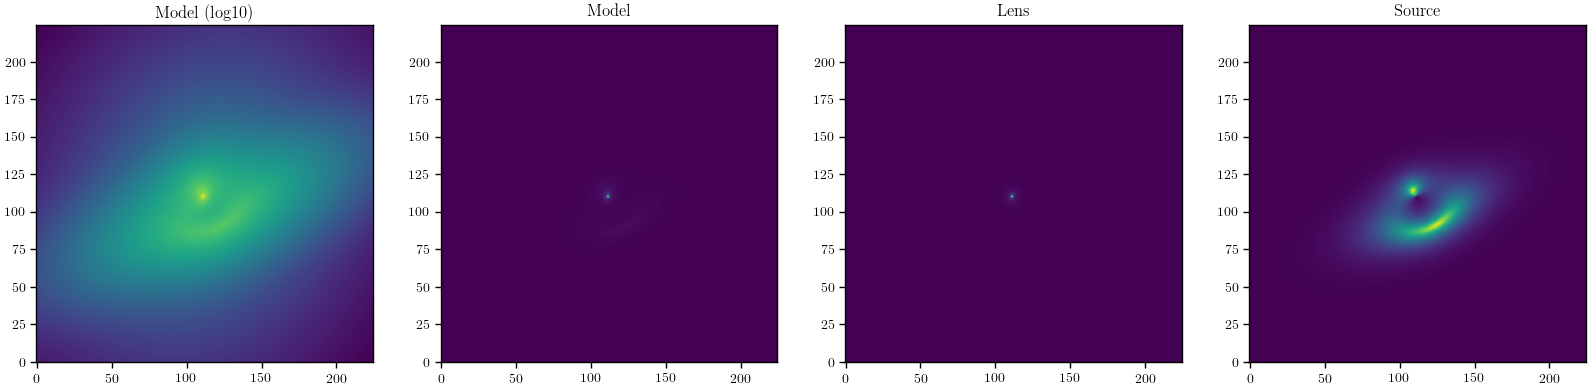

In [4]:
model, lens_sb, source_sb = sample_lens.get_array(45 * 5, 4.95, band, return_pieces=True)

f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(model))
ax[0].set_title('Model (log10)')
ax[1].imshow(model)
ax[1].set_title('Model')
ax[2].imshow(lens_sb)
ax[2].set_title('Lens')
ax[3].imshow(source_sb)
ax[3].set_title('Source')
plt.show()

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_5.pkl


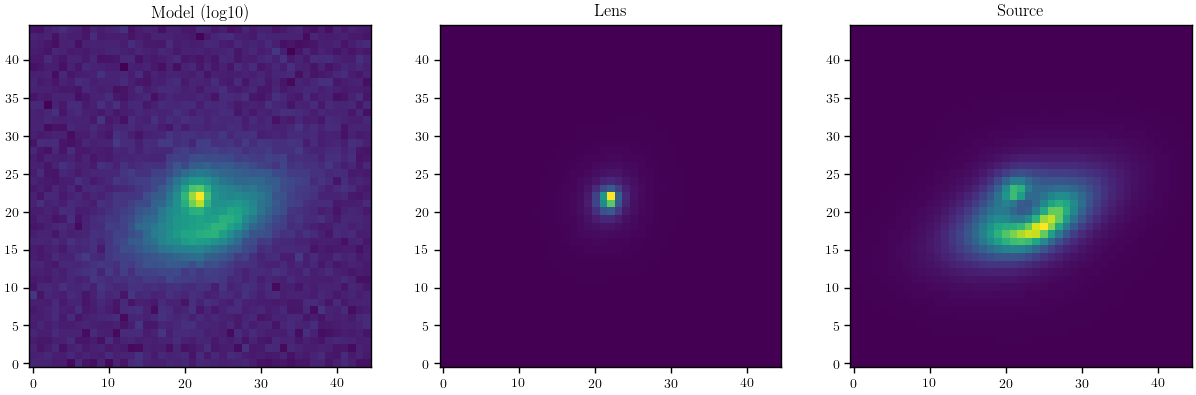

Execution time: 0:00:01


In [5]:
results, lenses, sources, execution_time = gs.get_images(sample_lens, [model], [band], 45, 45, 5, 5,
                                                         lens_surface_brightness=[lens_sb],
                                                         source_surface_brightness=[source_sb], detector=1,
                                                         detector_pos=(2048, 2048),
                                                         exposure_time=146, ra=30, dec=-30, seed=42, validate=False,
                                                         suppress_output=False, check_cache=True)

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(results[0]))
ax[0].set_title('Model (log10)')
ax[1].imshow(lenses[0])
ax[1].set_title('Lens')
ax[2].imshow(sources[0])
ax[2].set_title('Source')
plt.show()

print(f'Execution time: {execution_time}')

In [6]:
# put back into units of counts
total = results[0] * 146
lens = lenses[0] * 146
source = sources[0] * 146

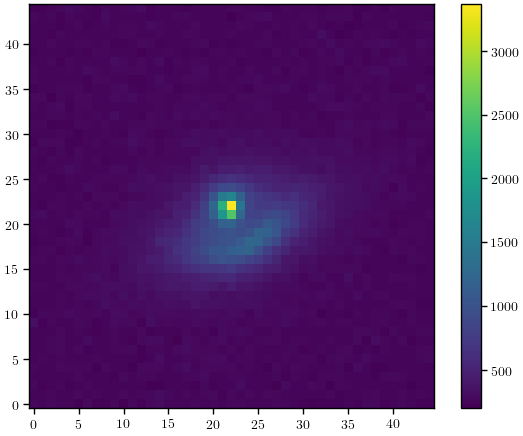

In [7]:
plt.imshow(total)
plt.colorbar()
plt.show()

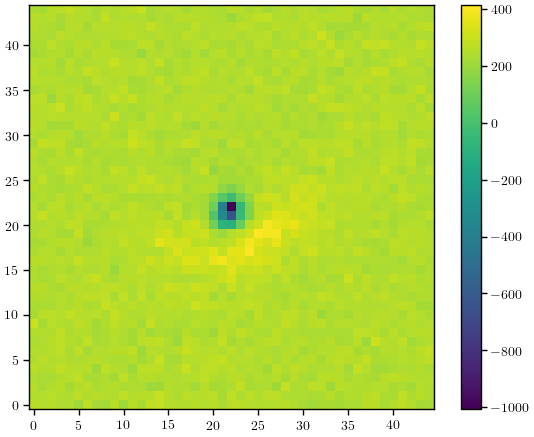

In [8]:
noise = total - (lens + source)

plt.imshow(noise)
plt.colorbar()
plt.show()

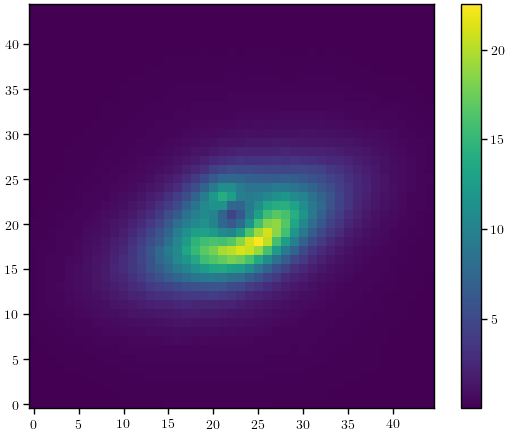

In [9]:
snr_array = source / np.sqrt(total)

plt.imshow(snr_array)
plt.colorbar()
plt.show()

In [24]:
snr_cutoff = 12

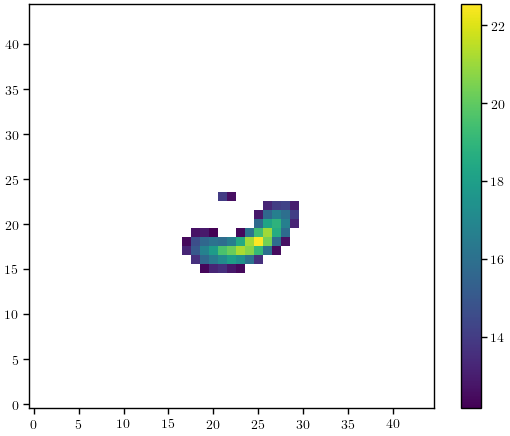

In [25]:
masked_snr_array = np.ma.masked_where(snr_array <= snr_cutoff, snr_array)

plt.imshow(masked_snr_array)
plt.colorbar()
plt.show()

In [26]:
if np.any(snr_array > snr_cutoff):
    print(f'There are regions with SNR > {snr_cutoff}')
else:
    print(f'There are no regions with SNR > {snr_cutoff}')

There are regions with SNR > 12


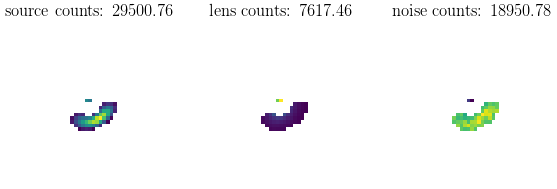

In [27]:
# mask source
masked_source = np.ma.masked_where(snr_array <= snr_cutoff, source)
source_counts = masked_source.compressed().sum()

# mask lens
masked_lens = np.ma.masked_where(snr_array <= snr_cutoff, lens)
lens_counts = masked_lens.compressed().sum()

# mask noise
masked_noise = np.ma.masked_where(snr_array <= snr_cutoff, noise)
noise_counts = masked_noise.compressed().sum()

f, ax = plt.subplots(1, 3)
ax[0].imshow(masked_source)
ax[0].set_title(f'source counts: {source_counts:.2f}')
ax[0].axis('off')
ax[1].imshow(masked_lens)
ax[1].set_title(f'lens counts: {lens_counts:.2f}')
ax[1].axis('off')
ax[2].imshow(masked_noise)
ax[2].set_title(f'noise counts: {noise_counts:.2f}')
ax[2].axis('off')
plt.show()

In [28]:
# calculate estimated SNR
snr = source_counts / np.sqrt(source_counts + lens_counts + noise_counts)
print(f'SNR: {snr}')

SNR: 124.58674621582031


In [29]:
from mejiro.analysis import regions

indices_list = regions.get_regions(masked_snr_array)

[(21, 23), (22, 23)]


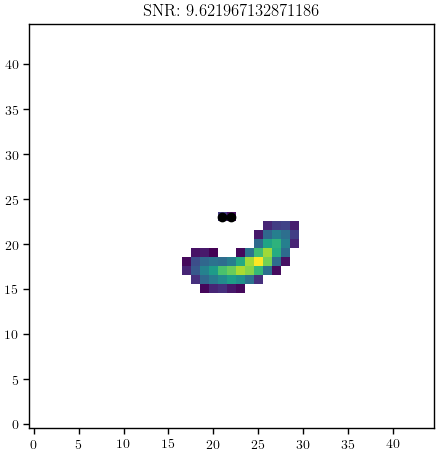

In [38]:
# region 1
plt.imshow(masked_snr_array)
region = indices_list[1]
print(region)

numerator, denominator = 0, 0
for i, j in region:
    numerator += source[i, j]
    denominator += source[i, j] + lens[i, j] + noise[i, j]
    plt.scatter(i, j, color='k')

snr = numerator / np.sqrt(denominator)
plt.title(f'SNR: {snr}')
plt.show()